## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo" https://www.uio.no/english/about/regulations/studies/studies-examinations/routines-cheating.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 19, 2021, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs.

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
import time

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [6]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [7]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [8]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [9]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

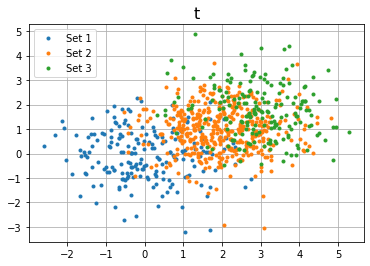

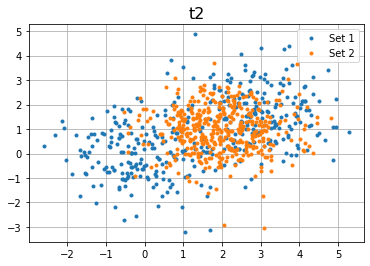

In [10]:
# Your solution
# plt.scatter(X_train, t_train)
def show(x, y, figure, marker="."):
    labels = set(y)
    plt.figure(figure)
    plt.title(figure, fontsize=16)
    for lab in labels:
        plt.plot(x[y == lab][:, 1], x[y == lab][:, 0], marker, label="Set {}".format(lab+1))
    plt.legend()
    plt.grid()

show(X_train, t_train, "t")
show(X_train, t2_train, "t2")

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [11]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
    

In [12]:

def add_bias(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    sh = X.shape
    m = sh[0]
    bias = np.ones((m,1)) # Make a m*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis  = 1) 

#Used for part 2, neural network
def add_neg_bias(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    sh = X.shape
    m = sh[0]
    bias = -1 * np.ones((m,1)) # Make a m*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis  = 1) 

In [13]:


class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)

        self.weights = weights = np.zeros(m+1)
        
        for e in range(epochs):
            #use the norm vs diff to see if we should end the training
            change = eta / k *  X_train.T @ (X_train @ weights - t_train)
            L2 = np.linalg.norm(change)
            if L2 > diff:
                weights -= change
            else:
                break
            
            #weights -= eta / k *  X_train.T @ (X_train @ weights - t_train)
            

    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold

s = time.time()
lin_cl = NumpyLinRegClass()
lin_cl.fit(X_train, t2_train, epochs=10000, diff=0.00003)
e = time.time()
print("Time:", e-s, "s.")
lin_accuracy = lin_cl.accuracy(X_val, t2_val)
print("Accuracy:", lin_accuracy)


Time: 0.05907464027404785 s.
Accuracy: 0.6075


### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [14]:
def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        for e in range(epochs):
            #use the norm vs diff to see if we should end the training
            change = eta / k *  X_train.T @ (self.forward(X_train) - t_train)
            L2 = np.linalg.norm(change)
            if L2 > diff:
                weights -= change
            else:
                break
    
    def forward(self, X):
        log = logistic(X @ self.weights)
        return log
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')
    
    def pure_score(self, x, threshold=0.5):
        #used for multiclass later in the assignment
        z = add_bias(x)
        score = self.forward(z)
        return score
    
lr_cl = NumpyLogReg()
lr_cl.fit(X_train, t2_train, epochs=200, diff=0.00231)
print("Time:", e-s, "s.")
log_accuracy = lr_cl.accuracy(X_val, t2_val)
print("Accuracy:", log_accuracy)



Time: 0.05907464027404785 s.
Accuracy: 0.6475


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You might have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, t2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [15]:
from collections import Counter

def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class NumpykNNClassifier(NumpyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, t_train):
        self.X_train = X_train
        self.t_train = t_train
    
    def predict(self, X_test):
        X = self.X_train
        t = self.t_train
        #convert week05 exercises to numpy array
        ret = np.zeros(X_test.shape[0])
        for a in range(X_test.shape[0]):
            distances = [(self.dist(X_test[a], b), b, c) for (b, c) in zip(X, t)]
            distances.sort()
            predictors = [c for (_,_,c) in distances[0: self.k]]
            ret[a] = majority(predictors)
        return ret
        
        
    
best_k = 14
cls = NumpykNNClassifier(k=best_k)
cls.fit(X_train, t2_train)
kNN_accuracy = cls.accuracy(X_val, t2_val)
print("Accuracy:", kNN_accuracy)
"""
After testing back and forth, the best K i could find was 14
"""

Accuracy: 0.7675


'\nAfter testing back and forth, the best K i could find was 14\n'

### Simple perceptron
Finally, run the simple perceptron (week06) on the same set, and report and store accuracy.

In [16]:
class NumpyPerClassifier(NumpyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        self.dim = m
        self.weights = weights = np.zeros(m+1)

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                weights -= eta * (y - t) * x
        
    def forward(self, X):
        """Calculate the score for the numpy array X"""
        score = X @ self.weights
        return score       
    
    def predict(self, X_test):
        """Predict the value for the item x"""
        z = add_bias(X_test)
        score = self.forward(z)
        return (score > 0).astype('int')
    

cl = NumpyPerClassifier()
cl.fit(X_train, t2_train, eta= 0.01, epochs = 15)
per_accuracy = cl.accuracy(X_val, t2_val)
print(per_accuracy)

0.5925


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

In [17]:
accs = np.array([lin_accuracy, log_accuracy, kNN_accuracy, per_accuracy])
print(accs)
"""
All results stay around 60%, this is to be expected as the data is rather random.
I was surprised to see how well kNN did compared to the other classifiers.
"""

[0.6075 0.6475 0.7675 0.5925]


'\nAll results stay around 60%, this is to be expected as the data is rather random.\nI was surprised to see how well kNN did compared to the other classifiers.\n'

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

In [18]:
k = 14
mul_knn = NumpykNNClassifier(k=k)
mul_knn.fit(X_train, t_train)
mul_knn_accuracy = mul_knn.accuracy(X_val, t_val)
print(mul_knn_accuracy)

0.77


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

In [19]:
# converts a target array into a 2d array of shape (t.length, max(t)+1), representing the one-hot array
def make_hot(t):
    big = max(t)+1
    hot = np.zeros(shape=(big, t.shape[0]))
    for i in range(big):
        hot[i] = np.array([t == i])
    return hot.T.astype('int')
    

In [20]:

class MulLogReg(NumpyLogReg):
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        hot_train = make_hot(t_train)
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(shape=[hot_train.shape[1], m+1])
        for i in range(hot_train.shape[1]):
            for e in range(epochs):
                #use the norm vs diff to see if we should end the training
                change = eta / k *  X_train.T @ (self.forward(X_train, i) - hot_train[:, i])
                L2 = np.linalg.norm(change)
                if L2 > diff:
                    weights[i] -= change
                else:
                    print("break", e)
                    break
                   
    def forward(self, X, i):
        return logistic(X @ self.weights[i])
        
    def predict(self, X_test):
        X_test = add_bias(X_test)
        scores = np.zeros(shape=[self.weights.shape[0], X_test.shape[0]])
        for i in range(scores.shape[0]):
            scores[i] = self.forward(X_test, i)
        scores = scores.T
        result = np.zeros(scores.shape[0])
        for i in range(scores.shape[0]):
            result[i] = np.argmax(scores[i])
        return result
        
mlr = MulLogReg()
mlr.fit(X_train, t_train)
print(mlr.accuracy(X_val, t_val))

0.585


Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

In [21]:
# The main difference in the two classes is how the weigths are handeled.
# In the multiclass one the weights are split into a 2d-array. 
# The rest of the methods are then adjusted to fit these weights.
# The predict method is also adjusteed in order to return an array from 0-number_of_classes, insted of a binary array.
# The results are much better in the multiclass testing, compared to the binary.
# I think the main reason for the difference is that the three classes are more clearly seperated than the binary,
# which can be seen in the graphs at the beginning of the assignment

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [22]:
X = np.concatenate((X_train, X_val, X_test))
features = np.array([X[:,0]**2, X[:,1]**2, X[:,0] * X[:,1]])

def add_feature(X):
    feat = np.zeros((X.shape[0], 1)).T
    feat[0] = features[X.shape[1]-2]
    feat = feat.T
    ret = np.concatenate((X, feat), axis  = 1)
    return ret

X2 = X
X2 = add_feature(X2)
X2 = add_feature(X2)
X2 = add_feature(X2)
X2_train = X2[:800]
X2_val = X2[800:1200]
X2_test = X2[1200:]

lirg = NumpyLinRegClass()
lorg = NumpyLogReg()
knn = NumpykNNClassifier(14)
per = NumpyPerClassifier()
lirg.fit(X2_train, t2_train, epochs=200, diff=0.001)
lorg.fit(X2_train, t2_train, epochs=2000, diff=0.002)
knn.fit(X2_train, t2_train)
per.fit(X2_train, t2_train, epochs=15, eta=0.001)
li_acc = lirg.accuracy(X2_val, t2_val)
lo_acc = lorg.accuracy(X2_val, t2_val)
knn_acc = knn.accuracy(X2_val, t2_val)
per_acc = per.accuracy(X2_val, t2_val)
print("Linear Regression:", li_acc)
print("Logarithmic Regression:", lo_acc)
print("K-Nearest Neighbours:", knn_acc)
print("Simple perceptron:", per_acc)
print(accs)

Linear Regression: 0.5275
Logarithmic Regression: 0.7075
K-Nearest Neighbours: 0.76
Simple perceptron: 0.635
[0.6075 0.6475 0.7675 0.5925]


| Features | Linear Regression | Logarithmic Regression | K-Nearest Neighbours | Simple Perceptron |
|----------|-------------------|------------------------|----------------------|-------------------|
| 2        | 0.6075            | 0.61                   | 0.755                | 0.5475            |
| 5        | 0.7075            | 0.74                   | 0.7425               | 0.5725            |

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

Text(0.5, 1.0, 'Scaled')

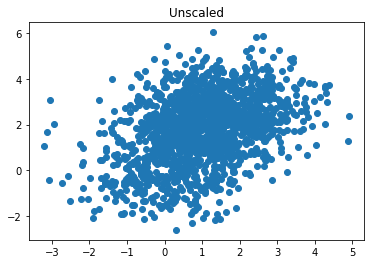

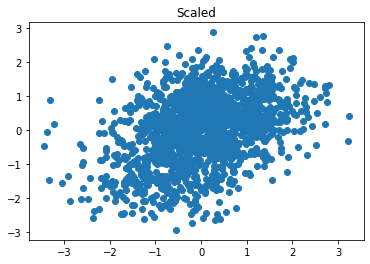

In [23]:
# Your code
x_1 = X[:,0]
x_2 = X[:,1]
plt.scatter(x_1, x_2)
plt.title("Unscaled")

mean_1 = np.mean(x_1)
mean_2 = np.mean(x_2)
std_1 = np.std(x_1)
std_2 = np.std(x_2)
x_1_scaled = (x_1 - mean_1)/std_1
x_2_scaled = (x_2 - mean_2)/std_2
X[:,0] = x_1_scaled
X[:,1] = x_2_scaled
X_train = X[:800]
X_val = X[800:1200]
X_test = X[1200:]
plt.figure()
plt.scatter(x_1_scaled, x_2_scaled)
plt.title("Scaled")

## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [24]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*. Beware that *t_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [38]:
dim_in =  0  # Calculate the correct value from the input data
dim_in = X_train.shape[1]
dim_out = 0  # Calculate the correct value from the input data
hot_t = make_hot(t_train)
dim_out = hot_t.shape[1]

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [39]:
# Your code
#Based on how to initialize weights in Marsland
weights1 = np.random.uniform(-1/np.sqrt(dim_in+1), 1/np.sqrt(dim_in+1), (dim_in+1, dim_hidden))
weights2 = np.random.uniform(-1/np.sqrt(dim_hidden+1), 1/np.sqrt(dim_hidden+1), (dim_hidden+1, dim_out))


### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [50]:
# Your code
bX = add_neg_bias(X_train)
hidden_activations = logistic(bX @ weights1)
bX.shape

(800, 3)

In [51]:
# Your code
hidden_activations = add_bias(hidden_activations)
output_activations = logistic(hidden_activations @ weights2)

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [60]:


# Your code

deltaO = (hot_t-output_activations)*output_activations*(1-output_activations)


Calculate the delta terms in the hidden layer.

In [61]:
# Your code

deltaH = hidden_activations*(1-hidden_activations)*(deltaO @ weights2.T)


Update the weights.
Check that they have changed.
As the weights depend on the random initialization, there is no unique correct solution at this point. But you should be able to see that the weights have been updated.

In [62]:

weights1 += eta*(bX.T @ deltaH[:,1:])
weights2 += eta*(hidden_activations.T @ deltaO)

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [63]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        # Initilaization
        # Fill in code for initalization
        dim_in = X_train.shape[1]
        dim_out = 0
        t_train = make_hot(t_train)
        
        dim_out = t_train.shape[1]
        X_train = add_neg_bias(X_train)
        
        self.weights1 = np.random.uniform(-1/np.sqrt(dim_in+1), 1/np.sqrt(dim_in+1), (dim_in+1, dim_hidden))
        self.weights2 = np.random.uniform(-1/np.sqrt(dim_hidden+1), 1/np.sqrt(dim_hidden+1), (dim_hidden+1, dim_out))
        
        for e in range(epochs):
            # Run one epoch of forward-backward
            # Fill in the code
            hidden, output = self.forward(X_train)
            # backward
            deltaO = (t_train-output)*output*(1-output)

            deltaH = hidden*(1-hidden)*(deltaO @ self.weights2.T)
            # update weights
            self.weights1 += eta*(X_train.T @ deltaH[:,1:])
            self.weights2 += eta*(hidden.T @ deltaO)

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        
        hidden_activations = add_neg_bias(logistic(X @ self.weights1))
        output_activations = logistic(hidden_activations @ self.weights2)
        return hidden_activations, output_activations
    
    def predict(self, X_test):
        X_test = add_neg_bias(X_test)
        hidden, output = self.forward(X_test)
        scores = np.zeros(output.shape[0])
        for i in range(scores.shape[0]):
            scores[i] = np.argmax(output[i])
        return scores.astype('int')
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
 

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [64]:

# values are based on contious testing
MNN = MNNClassifier(eta=0.0001, dim_hidden=200)
MNN.fit(X_train, t_train, epochs=80)
MNN.accuracy(X_val, t_val)

0.765

## Make a neural network classifier for (X, t2)
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train it on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result.

In [65]:
MNN2 = MNNClassifier(eta=0.0001, dim_hidden=25)
MNN2.fit(X_train, t2_train, epochs=200)
MNN2.accuracy(X_val, t2_val)

0.7575

## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [66]:
def conf_matrix_t(predicted, target):
    table = np.zeros(shape=[np.amax(predicted) + 1,np.amax(target) + 1])
    for p,g in zip(predicted, target):
        table[p, g] +=1
    print(33*" "+"Target")
    print("{:20}|{:>9}|{:>9}|{:>9}|".format(" ","Set 0", "Set 1", "Set 2"))
    print(10*" "+41*"-")
    print("{:10}{:10}|{:9}|{:9}|{:9}|".format(" ","Set 0",table[0,0], table[0,1], table[0,2]))
    print(10*" "+41*"-")
    print("Predicted {:10}|{:9}|{:9}|{:9}|".format("Set 1",table[1,0], table[1,1], table[1, 2]))
    print(10*" "+41*"-")
    print("{:10}{:10}|{:9}|{:9}|{:9}|".format(" ","Set 2",table[2,0], table[2,1], table[2,2]))
    print(10*" "+41*"-")
    
def conf_matrix_t2(predicted, Target):
    table = np.zeros((2,2))
    for p,g in zip(predicted, Target):
        table[int(p), g] +=1
    print(28*" "+"Target")
    print("{:20}|{:>9}|{:>9}|".format(" ","0", "1"))
    print(10*" "+31*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","0",table[0,0], table[0,1]))
    print("Predicted "+31*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","1",table[1,0], table[1,1]))
    print(10*" "+31*"-")

def precision(predicted, target, c):
    tp = 0
    for i in range(predicted.shape[0]):
        if predicted[i] == c and target[i] == c:
            tp += 1
    return tp / np.count_nonzero(predicted == c, axis = 0)
            

def recall(predicted, target, c):
    tp = 0
    for i in range(predicted.shape[0]):
        if predicted[i] == c and target[i] == c:
            tp += 1
    return tp / np.count_nonzero(target == c, axis = 0)

In [67]:
from sklearn import metrics as m
# After adjusting values for the MNN it proved to be the best for both datasets.
# However, due to the random initialisation of the weights, the results may vary.

print("Accuracy for X, t on MNN:", MNN.accuracy(X_test, t_test))
print("Accuracy for X, t2 on MNN:", MNN2.accuracy(X_test, t2_test))
# The accuracy differs somewhat from the validation set, but stays rather close for the most part.
# The results differ each time the MNN and MNN2 are initialized anew.
print("\n\nConfusion matrix for t")
predict = MNN.predict(X_test)
conf_matrix_t(predict, t_test)

print("\n\nConfusion matrix for t2")
predict2 = MNN2.predict(X_test)
conf_matrix_t2(predict2, t2_test)

print("\n\nPrecision t")
for i in range(3):
    print("Set {:1}: {:.2f}".format(i, precision(predict, t_test, i)))
print("\n\nRecall t")
for i in range(3):
    print("Set {:1}: {:.2f}".format(i, recall(predict, t_test, i)))

print("\n\nPresicion t2")
print("Set {:1}: {:.2f}".format(0, precision(predict, t_test, 0)))
print("Set {:1}: {:.2f}".format(1, precision(predict, t_test, 1)))

print("\n\nRecall t2")
print("Set {:1}: {:.2f}".format(0, recall(predict, t_test, 0)))
print("Set {:1}: {:.2f}".format(1, recall(predict, t_test, 1)))

Accuracy for X, t on MNN: 0.7375
Accuracy for X, t2 on MNN: 0.765


Confusion matrix for t
                                 Target
                    |    Set 0|    Set 1|    Set 2|
          -----------------------------------------
          Set 0     |     74.0|     14.0|      0.0|
          -----------------------------------------
Predicted Set 1     |     18.0|    173.0|     65.0|
          -----------------------------------------
          Set 2     |      0.0|      8.0|     48.0|
          -----------------------------------------


Confusion matrix for t2
                            Target
                    |        0|        1|
          -------------------------------
          0         |    145.0|     34.0|
Predicted -------------------------------
          1         |     60.0|    161.0|
          -------------------------------


Precision t
Set 0: 0.84
Set 1: 0.68
Set 2: 0.86


Recall t
Set 0: 0.80
Set 1: 0.89
Set 2: 0.42


Presicion t2
Set 0: 0.84
Set 1: 0.68


Re